In [1]:
import time
import numpy as np
from scipy import signal
from scipy import fftpack
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import f06_postpro as f06
import dat_tools as dat
import utils
import rfp
import oma
import mac

In [2]:
# Diccionario de conexiones nodales
# connect_dict = {'1': ['11', '12', '13', '14'],
#               '11': ['12', '14'],
#               '13': ['12', '14'],
#               '15': ['16', '18'],
#               '17': ['16', '18']}
# connect_dict = {'1': ['11', '12', '13', '14'],
#               '11': ['12', '14', '19'],
#               '12': ['22'],
#               '13': ['12', '14', '21'],
#               '14': ['20'],
#               '15': ['16', '18', '19'],
#               '16': ['22'],
#               '17': ['16', '18', '21'],
#               '18': ['20'],
#               '23': ['11', '14', '15', '18'],
#               '24': ['13', '14', '17', '18'],
#               '25': ['12', '13', '16', '17'],
#               '26': ['11', '12', '15', '16'],
#               '27': ['15', '16', '17', '18']}
connect_dict = {'1': ['11', '12', '13', '14'],
              '11': ['12', '14', '19'],
              '12': ['20'],
              '13': ['12', '14', '21'],
              '14': ['22'],
              '15': ['16', '18', '19'],
              '16': ['20'],
              '17': ['16', '18', '21'],
              '18': ['22'],
              '23': ['11', '14', '15', '18'],
              '24': ['13', '14', '17', '18'],
              '25': ['12', '13', '16', '17'],
              '26': ['11', '12', '15', '16'],
              '27': ['15', '16', '17', '18', '28']}

### Funciones de transferencia nodales por simulación

In [3]:
freq, accel, nodes = f06.read_nodes_accel('C:\RUNRUN\sate_subassembly_sinex.f06')
coords = dat.read_node_coords('C:\RUNRUN\sate_subassembly_sinex.dat', nodes)
# freq, accel, nodes = f06.read_nodes_accel('C:\RUNRUN\sate_corners_sinex.f06')
# coords = dat.read_node_coords('C:\RUNRUN\sate_corners_sinex.dat', nodes)
# mode_freqs, modes_theo_premask = f06.read_modeshapes(r'C:\Users\rafa\Tesis\Modelos\sate_plano_s-modal-hm.f06', nodes)
mode_freqs_all, modes_theo_all = f06.read_modeshapes(r'D:\Tesis\Modelos\sate_subassembly_s-modal-hm.f06', nodes)

Max value off diagonal: 0.937


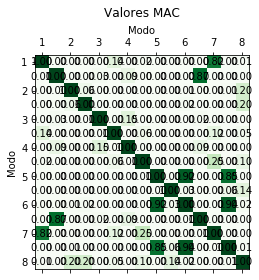

In [4]:
MAC_theo = mac.get_MAC_matrix(modes_theo_all.T[:,:15], modes_theo_all.T[:,:15])
mac.plot_MAC(MAC_theo, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_theo)))

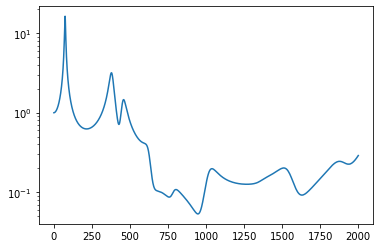

In [5]:
plt.semilogy(freq, np.abs(accel['28'][:,0]))

In [6]:
# Transfer matrix
input_node = 1
input_node_str = str(input_node)

TF_dict = accel.copy()
# Delete input node
if input_node_str in TF_dict: del TF_dict[input_node_str]

total_nodes = len(TF_dict.keys())
dof_per_node = 3
total_dofs = total_nodes * dof_per_node
TF = np.zeros((len(freq), total_dofs), dtype=complex)
node_order = dict()
node_order['1'] = 0 # nodo origen
dof_order = dict()
col = 0
for node_str in TF_dict.keys():
    dof_order[node_str] = col
    node_order[node_str] = (col+3)//3 # dejo lugar para nodo del origen
    TF[:,col:col+3] = TF_dict[node_str]
    col += 3

In [7]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:total_dofs]

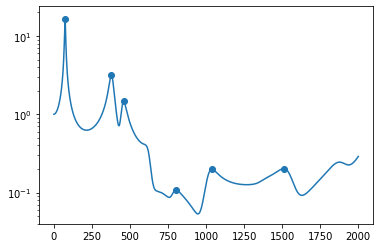

In [8]:
DOF = 51
mode_ind_TF = np.array([m for m in signal.argrelmax(np.abs(TF[:, DOF]), order=50)]).flatten()
plt.semilogy(freq, np.abs(TF[:, DOF]))
plt.scatter(freq[mode_ind_TF], np.abs(TF[mode_ind_TF, DOF]))

In [9]:
mask = [np.argmin(np.abs(mode_freqs_all - freq[mode_idx])) for mode_idx in mode_ind_TF]
mode_freqs = mode_freqs_all[mask]
modes_theo = modes_theo_all[mask,3:].T

Max value off diagonal: 0.928


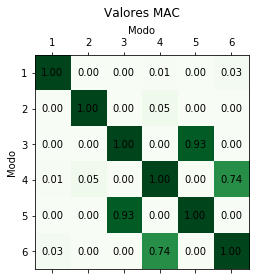

In [10]:
MAC_theo = mac.get_MAC_matrix(modes_theo, modes_theo)
mac.plot_MAC(MAC_theo, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_theo)))

Max value off diagonal: 0.809


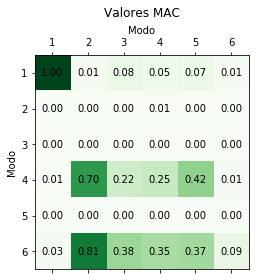

In [11]:
MAC_theo = mac.get_MAC_matrix(modes_theo, TF[mode_ind_TF, :].T)
mac.plot_MAC(MAC_theo, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_theo)))

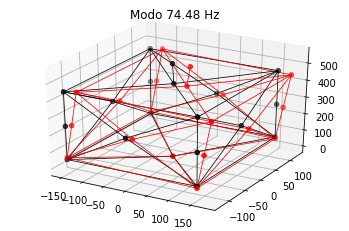

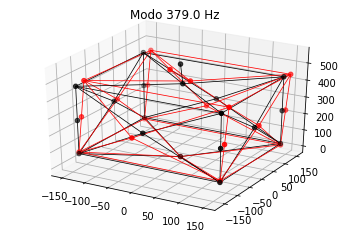

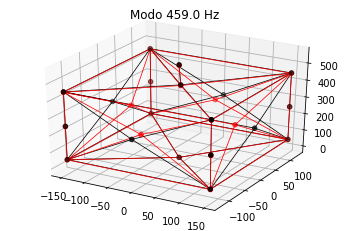

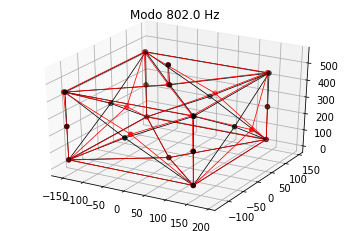

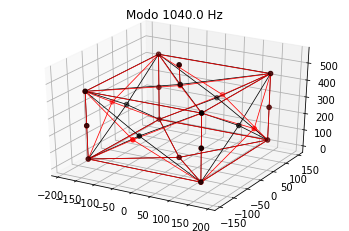

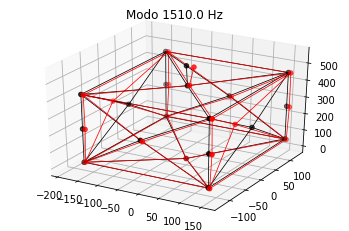

In [12]:
for mode_idx in range(modes_theo.shape[1]):
    mode_shape = modes_theo[:, mode_idx]
    mode_name = 'Modo {} Hz'.format(np.round(freq[mode_ind_TF[mode_idx]], 2))
    utils.plot_3d_mode(node_order, coords, connect_dict, mode_shape, mode_name, magnif=40)

### Ruido blanco en la base

In [13]:
g_rms = 1
t_end = 120
f_s = 1200
delta_t = 1/f_s
t = np.linspace(0, t_end, int(t_end/delta_t))
Ug_time = g_rms * np.random.normal(size=len(t))

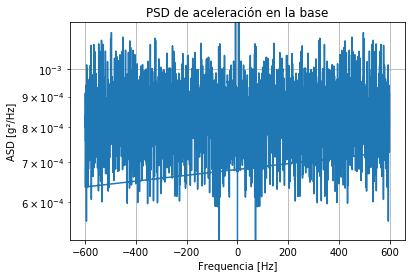

In [14]:
# PSD de aceleraciones en la base
nperseg = 4096
Ug_psd_freq, Ug_psd = signal.welch(Ug_time, 
                      fs=f_s, # sample rate
                      window='hamming', # apply a Hanning window before taking the DFT
                      nperseg=nperseg, # compute periodograms of 256-long segments of x
                      detrend='constant', # detrend x by subtracting the mean)
                      return_onesided=False)

plt.figure()
plt.semilogy(Ug_psd_freq, Ug_psd)
plt.title('PSD de aceleración en la base')
plt.ylim([np.min(Ug_psd[1:]), np.max(Ug_psd[1:])])
plt.xlabel('Frequencia [Hz]')
plt.ylabel('ASD [g²/Hz]')
plt.grid()
plt.show()

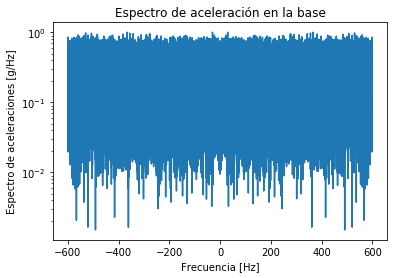

In [15]:
# Transformada de Fourier de aceleraciones en la base
Ug_fft_twosided = np.fft.fft(Ug_time) * delta_t
Ug_fft_freq_twosided = np.fft.fftfreq(len(t), d=delta_t)
# onesided_2kHz_size = len(Ug_fft_twosided)//4
# delta_t_2kHz = delta_t * 2
# Ug_fft_freq = Ug_fft_freq_twosided[:onesided_2kHz_size]
# Ug_fft = 2*Ug_fft_twosided[:onesided_2kHz_size]
Ug_fft = Ug_fft_twosided
Ug_fft_freq = Ug_fft_freq_twosided
plt.figure()
plt.semilogy(Ug_fft_freq, abs(Ug_fft))
plt.title('Espectro de aceleración en la base')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Espectro de aceleraciones [g/Hz]')
plt.show()

In [16]:
Ug_fft_freq

array([ 0.        ,  0.00833333,  0.01666667, ..., -0.025     ,
       -0.01666667, -0.00833333])

### Respuestas nodales

In [17]:
# Interpolacion de transferencias las frecuencias de excitación
TF_inter = np.zeros((len(Ug_fft_freq), TF.shape[1]), dtype=complex)
for dof in range(TF.shape[1]):
    TF_inter[:,dof] = np.interp(Ug_fft_freq, freq, TF[:,dof])

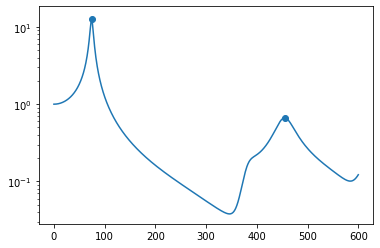

In [18]:
mode_ind_TFint = np.array([m for m in signal.argrelmax(np.abs(TF_inter[:, 21]), order=180)]).flatten()
plt.semilogy(Ug_fft_freq[:len(Ug_fft_freq)//2], np.abs(TF_inter[:len(Ug_fft_freq)//2,21]))
plt.scatter(Ug_fft_freq[mode_ind_TFint], np.abs(TF_inter[mode_ind_TFint,21]))

In [19]:
# Espectros de respuesta
ddotY_fft = (TF_inter.T*Ug_fft).T

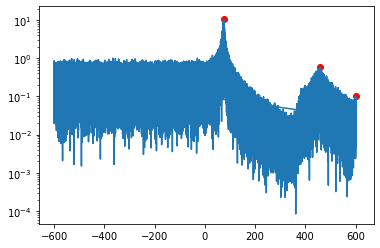

In [20]:
mode_ind_fft = np.array([m for m in signal.argrelmax(np.abs(ddotY_fft[:len(Ug_fft_freq)//2, 21]), order=4000)]).flatten()
plt.semilogy(Ug_fft_freq, np.abs(ddotY_fft[:,21]))
plt.scatter(Ug_fft_freq[mode_ind_fft], np.abs(ddotY_fft[mode_ind_fft,21]), color='r')

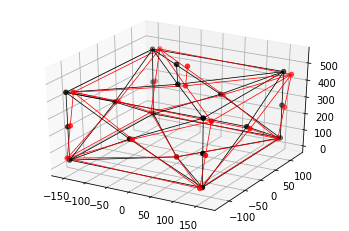

In [21]:
utils.plot_3d_mode(node_order, coords, connect_dict, ddotY_fft[mode_ind_fft[0], :], magnif=100)

In [22]:
mac.get_MAC(modes_theo[:,0], ddotY_fft[mode_ind_fft[0], :])

0.9952398519766363

In [23]:
# Respuestas temporales
ddotY_time = fftpack.ifft(ddotY_fft, axis=0)

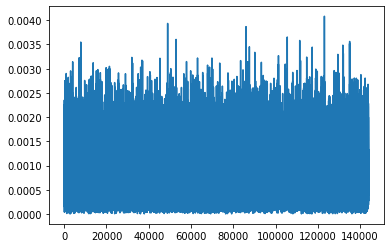

In [24]:
plt.plot(np.abs(ddotY_time[:,15]))

## GRFP

#### Estimador H1 de la FRF

In [25]:
S_xf = np.zeros((nperseg, total_dofs), dtype=complex)
for dof in range(total_dofs):
        f_Sxf, S_xf[:, dof] = signal.csd(ddotY_time[:, dof], Ug_time,
                                               fs=f_s,
                                               window='hanning',
                                               nperseg=nperseg,
                                               detrend='constant',
                                               axis=0,
                                               return_onesided=False)

In [26]:
f_H = f_Sxf[:len(f_Sxf)//2]
H1_premask = S_xf[:len(f_H),:]/Ug_psd[:len(f_H), np.newaxis]
# H1 = np.copy(H1_premask[:,mask[3:]])
H1 = H1_premask

In [27]:
DOF = 21
mode_ind_H1 = np.array([m for m in signal.argrelmax(np.abs(H1[:len(f_H), DOF]), order=400)]).flatten()

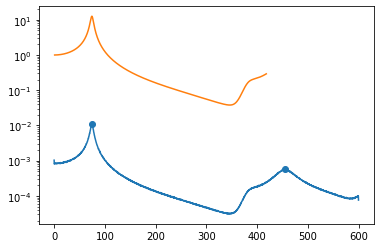

In [28]:
plt.semilogy(f_H[:len(f_H)], np.abs(H1[:len(f_H), DOF]))
plt.semilogy(freq[:len(f_H)//2], np.abs(accel['18'][:len(f_H)//2,0]))
plt.scatter(f_H[mode_ind_H1], np.abs(H1[mode_ind_H1, DOF]))

In [29]:
f_H[mode_ind_H1]

array([ 74.12109375, 455.2734375 ])

In [30]:
n_modes = 2
m = 2*n_modes-1
n = 2*n_modes
freq_range = [50, 500]
DOF = 21
idxes = np.where((f_H >= freq_range[0]) & (f_H <=freq_range[1]))[0]
modal_params, alpha = rfp.rfp(H1[idxes, DOF].T, 2*np.pi*f_H[idxes], n, m)
# modal_params2, alpha2 = rfp.rfp(accel['18'][50:len(freq)//8,0], 2*np.pi*freq[50:len(freq)//8], n, m)

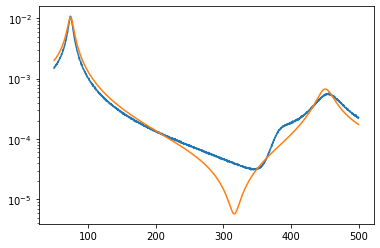

In [31]:
plt.semilogy(f_H[idxes], np.abs(H1[idxes, DOF]))
plt.semilogy(f_H[idxes], np.abs(alpha))
# plt.ylim([0.005, 0.05])
# plt.xlim([70, 80])
# plt.semilogy(freq[:len(f_H)//8], np.abs(accel['18'][:len(f_H)//8,0]))
# plt.semilogy(freq[50:len(freq)//8], np.abs(alpha2))

In [32]:
print(modal_params)
# print(modal_params2)

[array([ 74.60757512, 450.43268502]), array([-0.05280692, -0.02588932]), array([240.51466688, 276.5418744 ]), array([-0.05914923, -0.3611987 ])]


In [33]:
DOFS = np.array([20, 21])
n_modes = 4
m = 2*n_modes-1
n = 2*n_modes
denom, denom_coeff = rfp.grfp_denominator(H1[idxes[:, np.newaxis], DOFS], 2*np.pi*f_H[idxes],n,m)

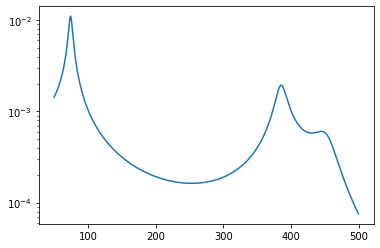

In [34]:
plt.semilogy(f_H[idxes], np.abs(1/denom))

In [35]:
[freq_n, xi_n, modal_mag_n, modal_ang_n], alpha1 = rfp.grfp_parameters(H1[idxes,:], 2*np.pi*f_H[idxes], denom, denom_coeff, m)
print(freq_n)
print(xi_n)

[ 74.45002647 385.38080459 453.2085547 ]
[-0.03681523  0.02081642 -0.03551823]


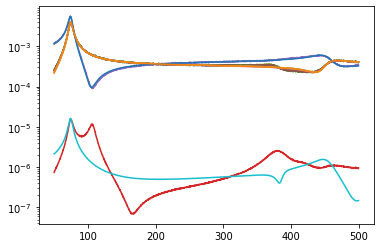

In [36]:
# DOFS = np.array([20,  21])
DOFS = np.array([5, 17, 23, 25, 33,35])
plt.semilogy(f_H[idxes], np.abs(H1[idxes[:, np.newaxis], DOFS]))
plt.semilogy(f_H[idxes], np.abs(alpha1[:,DOFS]))

Max value off diagonal: 0.877


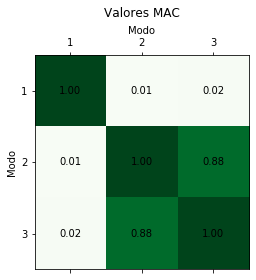

In [37]:
modes_grfp = (modal_mag_n*np.exp(1j*modal_ang_n)).T
MAC_grfp = mac.get_MAC_matrix(modes_grfp, modes_grfp)
mac.plot_MAC(MAC_grfp, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_grfp)))

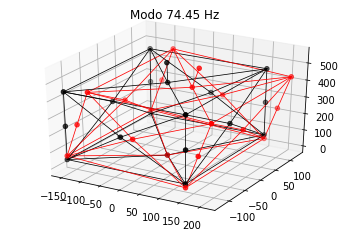

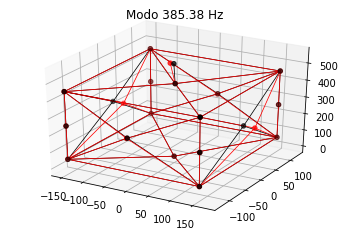

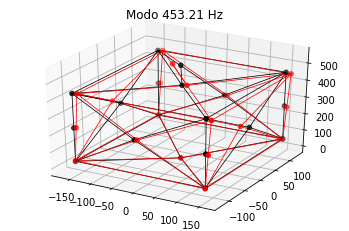

In [38]:
for mode_idx in range(modes_grfp.shape[1]):
    mode_shape = modes_grfp[:,mode_idx]
    mode_name = 'Modo {} Hz'.format(np.round(freq_n[mode_idx], 2))
    utils.plot_3d_mode(node_order, coords, connect_dict, mode_shape, mode_name, magnif=80)

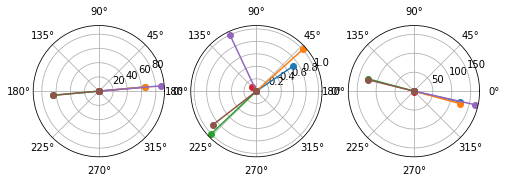

In [39]:
fix, ax = plt.subplots(1, modes_grfp.shape[1], subplot_kw=dict(polar=True), figsize=(8,10))
for mode in range(modes_grfp.shape[1]):
    for dof in range(DOFS.size):
        ax[mode].plot([0, np.angle(modes_grfp[DOFS[dof], mode])],
                 [0, np.abs(modes_grfp[DOFS[dof], mode])],
                 marker='o')

Max value off diagonal: 0.856


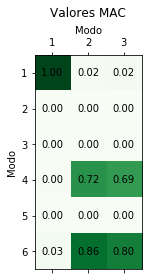

In [40]:
MAC_grfp = mac.get_MAC_matrix(modes_theo, modes_grfp)
mac.plot_MAC(MAC_grfp, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_grfp)))

## FDD

#### Matriz de densidades espectrales de la respuesta

In [41]:
S_xx = np.zeros((nperseg, total_dofs, total_dofs), dtype=complex)

start = time.time()
for dof1 in range(total_dofs):
    for dof2 in range(total_dofs):
        f_S, S_xx[:, dof1, dof2] = signal.csd(ddotY_time[:, dof1], ddotY_time[:, dof2],
                                                               fs=f_s,
                                                               window='hanning',
                                                               nperseg=nperseg,
                                                               detrend='constant',
                                                               axis=0,
                                                               return_onesided=False)
end = time.time()
print(end - start)

56.66142725944519


In [42]:
# Extraigo frecuencias y formas de modo por SVD
u_fdd, s_fdd, vh_fdd = np.linalg.svd(S_xx)

freq_fdd = f_S[:len(f_S)//2]
# Maximos del primer valor singular
mode_ind_fdd = np.array([m for m in signal.argrelmax(s_fdd[:len(f_S)//2, 0], order=200)]).flatten()

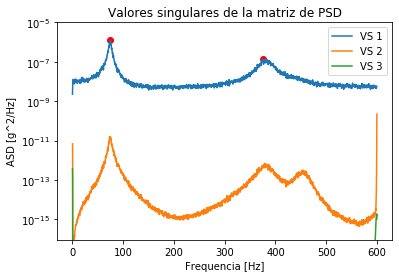

In [43]:
plt.semilogy(freq_fdd, s_fdd[:len(freq_fdd), :3])
plt.ylim([np.min(s_fdd[10:len(freq_fdd), 1]), None])
plt.scatter(freq_fdd[mode_ind_fdd[:4]],
            abs(s_fdd[mode_ind_fdd[:4], 0]),
            color='r')
plt.title('Valores singulares de la matriz de PSD')
plt.ylabel('ASD [g^2/Hz]')
plt.xlabel('Frequencia [Hz]')
lgnd  = ['VS {}'.format(col+1) for col in range(3)]
plt.legend(lgnd, loc='upper right')
plt.show()

In [44]:
fdd_total_modes = 3
freq_fdd[mode_ind_fdd[:fdd_total_modes]]

array([ 74.70703125, 375.        ])

IndexError: index 2 is out of bounds for axis 0 with size 2

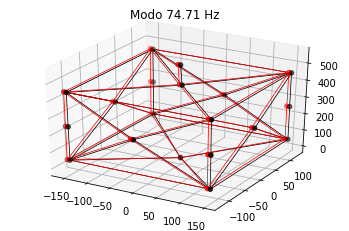

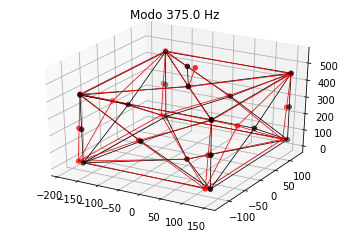

In [46]:
for mode_idx in range(fdd_total_modes):
    mode_shape = u_fdd[mode_ind_fdd[mode_idx], :, 0]
    mode_name = 'Modo {} Hz'.format(np.round(freq_fdd[mode_ind_fdd[mode_idx]], 2))
    utils.plot_3d_mode(node_order, coords, connect_dict, mode_shape, mode_name, magnif=100)

Max value off diagonal: 0.788


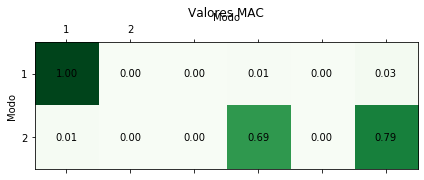

In [47]:
modes_fdd = u_fdd[mode_ind_fdd[:fdd_total_modes],:,0].T
MAC_fdd = mac.get_MAC_matrix(modes_fdd, modes_theo)
mac.plot_MAC(MAC_fdd, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_fdd)))

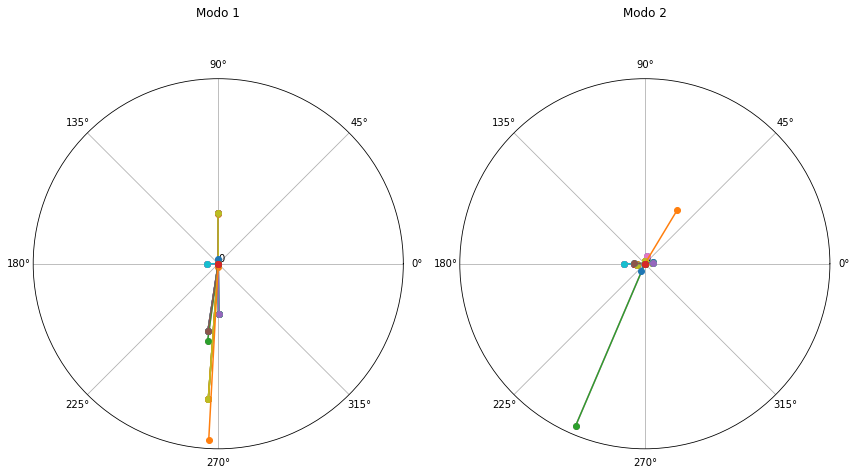

In [48]:
utils.plot_modes_complexity(modes_fdd)

### EFDD

In [50]:
mac_th = 0.7
sdof_psd = np.zeros((f_S.size, fdd_total_modes), dtype=complex)
sdof_acf = np.zeros((f_S.size, fdd_total_modes), dtype=complex)
t_sdof_acf = np.linspace(0, sdof_psd.shape[0]*delta_t, sdof_psd.shape[0])
f_efdd = np.zeros(fdd_total_modes)
xi_efdd = np.zeros(fdd_total_modes)
R2 = np.zeros(fdd_total_modes)

for mode in range(fdd_total_modes):
    peak_idx = mode_ind_fdd[mode]
    idx_low, idx_high = oma.get_efdd_segment(u_fdd, peak_idx, mac_th)
    sdof_psd[idx_low:idx_high, mode] = s_fdd[idx_low:idx_high, 0]
    sdof_acf[:, mode] = fftpack.ifft(sdof_psd[:, mode])
    decay = sdof_acf[:, mode].real[:len(t_sdof_acf)//2]
    xi_efdd[mode], R2[mode], A, b, c, m = oma.get_damp_from_decay(decay)
    f_efdd_damped = oma.get_freq_from_signal(t_sdof_acf, sdof_acf[:, mode])
    f_efdd[mode] = f_efdd_damped / np.sqrt(1-xi_efdd[mode]**2)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [51]:
print(f_efdd)
print(xi_efdd)

[ 74.67181829 379.60773672   0.        ]
[0.00360463 0.00078478 0.        ]


In [52]:
modes_efdd = np.zeros((u_fdd.shape[1], fdd_total_modes), dtype=complex)
for mode in range(fdd_total_modes):
    peak_idx = mode_ind_fdd[mode]
    seg_idxes = oma.get_efdd_segment(u_fdd, peak_idx, mac_th)
    modes_efdd[:, mode] = oma.get_mean_modeshape_efdd(segment_idxes=seg_idxes,
                                                      peak_idx=peak_idx,
                                                      s_vectors=u_fdd)

# Normalización
for col in range(modes_efdd.shape[1]):
    modes_efdd[:,col] = modes_efdd[:,col]/max(abs(modes_efdd[:,col]))

IndexError: index 2 is out of bounds for axis 0 with size 2

Max value off diagonal: nan


C:\Users\rafa\projects\atelier\mac.py:9: RuntimeWarning: invalid value encountered in double_scalars
  (abs(mode_A.T @ mode_A.conj()) * abs(mode_B.T @ mode_B.conj()))


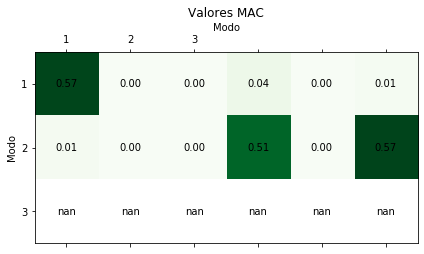

In [53]:
MAC_efdd = mac.get_MAC_matrix(modes_efdd, modes_theo)
mac.plot_MAC(MAC_efdd, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_efdd)))

### CFDD

C:\Users\rafa\projects\atelier\oma.py:121: RuntimeWarning: invalid value encountered in double_scalars
  w_n = 1/x[1]**0.25


IndexError: index 2 is out of bounds for axis 0 with size 2

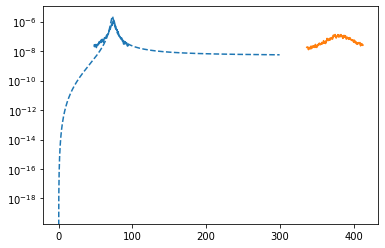

In [54]:
mac_th = 0.8
cfdd_total_modes = 4
f_cfdd = np.zeros(cfdd_total_modes)
xi_cfdd = np.zeros(cfdd_total_modes)

freq_hat = np.linspace(0, f_S[len(f_S)//2-1], 4000)
psd_hat = np.zeros((freq_hat.size, cfdd_total_modes))

for mode in range(cfdd_total_modes):
    peak_idx = mode_ind_fdd[mode]
    efdd_idxes = oma.get_efdd_segment(u_fdd, peak_idx, mac_th)
    f_cfdd[mode], xi_cfdd[mode], psd_hat[:, mode] = oma.curve_fit_psd_peak(f_S[:len(f_S)//2], s_fdd[:len(f_S)//2, 0], efdd_idxes, freq_hat)
    
    plt.semilogy(f_S[efdd_idxes[0]:efdd_idxes[1]],
                 abs(s_fdd[efdd_idxes[0]:efdd_idxes[1], 0]),
                 color=colors[mode])
    plt.semilogy(freq_hat[:freq_hat.size//2],
                 abs(psd_hat[:freq_hat.size//2, mode]),
                 color=colors[mode],
                 linestyle='--')

plt.title('Ajuste por CFDD de picos de PSD')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('PSD [g^2/Hz]')
# plt.ylim([np.min(s_fdd[:, 0]), None])

In [55]:
f_cfdd

array([72.80611863,         nan,  0.        ,  0.        ])

In [56]:
xi_cfdd

array([0.02315715,        nan, 0.        , 0.        ])